#### Импортируем модули, которые нам понадобятся

In [70]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации
 
from sklearn import metrics #метрики
from sklearn import model_selection #методы разделения и валидации
from sklearn import linear_model #линейные модели
from sklearn import tree #деревья решений
plt.style.use('seaborn') #стиль отрисовки seaborn
%matplotlib inline

C:\Users\insps\AppData\Local\Temp\ipykernel_22372\3755730.py:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn') #стиль отрисовки seaborn


#### Прочитаем данные о собранных образцах воды

[Описание датасета и пизнаков](https://www.kaggle.com/datasets/adityakadiwal/water-potability)

In [2]:
water_data = pd.read_csv('https://lms.skillfactory.ru/assets/courseware/v1/9cd645af21ef409ff23bf03a783b4b71/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block/water_potability.zip')
water_data.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


#### В данных есть пропуски. Выведем информацию о них в процентном соотношении

In [3]:
display(water_data.isnull().mean() * 100)

ph                 14.987790
Hardness            0.000000
Solids              0.000000
Chloramines         0.000000
Sulfate            23.840049
Conductivity        0.000000
Organic_carbon      0.000000
Trihalomethanes     4.945055
Turbidity           0.000000
Potability          0.000000
dtype: float64

#### Заполним пропуски медианным значением в признаке зависимости класса воды (Potability). Для этого сгруппируем данные по признаку Potability, посчитаем медиану в каждой группе, а затем отправим результат в метод fillna()

In [4]:
#Заполняем пропуски
water_data['ph'] = water_data['ph'].fillna(water_data.groupby('Potability')['ph'].transform('median'))
water_data['Sulfate'] = water_data['Sulfate'].fillna(water_data.groupby('Potability')['Sulfate'].transform('median'))
water_data['Trihalomethanes'] = water_data['Trihalomethanes'].fillna(water_data.groupby('Potability')['Trihalomethanes'].transform('median'))

display(water_data.isnull().mean() * 100)

ph                 0.0
Hardness           0.0
Solids             0.0
Chloramines        0.0
Sulfate            0.0
Conductivity       0.0
Organic_carbon     0.0
Trihalomethanes    0.0
Turbidity          0.0
Potability         0.0
dtype: float64

In [5]:
X = water_data.drop('Potability', axis=1)
y = water_data['Potability']

## Метод hold-out (отложенная выборка)

#### Метод hold-out реализован в уже знакомой вам функции train_test_split(). Она предназначена для разбиения исходного набора данных случайным образом на две части в заданных соотношениях.

In [6]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

print('Train shape: {}'.format(X_train.shape))
print('Valid shape: {}'.format(X_valid.shape))

Train shape: (2620, 9)
Valid shape: (656, 9)


#### Далее нам останется только обучить модель на тренировочной выборке (X_train, y_train) и рассчитать метрики на валидационной выборке (X_valid, y_valid). В качестве модели будем использовать дерево решений с максимальной глубиной 7, энтропией в качестве критерия информативности, минимальное число объектов в листе дерева — 5. После обучения сделаем предсказание для каждой из выборок и рассчитаем метрику. В качестве метрики для простоты возьмём долю правильных ответов — accuracy.

In [7]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42 #генератор случайных чисел  
)
#Обучаем модель на тренировочной выборке
model.fit(X_train, y_train)
#Делаем предсказание для каждой из выборок
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)
#Выводим значения метрик
print('Train hold-out accuracy: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
print('Valid hold-out accuracy: {:.2f}'.format(metrics.accuracy_score(y_valid, y_valid_pred))) 

Train hold-out accuracy: 0.82
Valid hold-out accuracy: 0.77


#### Если же мы используем трёхкомпонентный подход (разбиваем выборку на тренировочную, валидационную и отдельную тестовую), нам понадобится чуть больше кода. К сожалению, в sklearn нет специализированного функционала для такого разбиения. Применим функцию train_test_split() дважды: сначала разобьём исходный набор на тренировочный и валидационный в соотношении 80/20, затем разобьём валидационный набор на валидационный и тестовый в соотношении 50/50. В итоге наша выборка будет разбита в соотношении 80/10/10:

In [8]:
#разбиваем исходную выборку на тренировочную и валидационную в соотношении 80/20
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)
#разбиваем валидационную выборку на валидационную и тестовую в соотношении 50/50
X_valid, X_test, y_valid, y_test = model_selection.train_test_split(X_valid, y_valid, test_size=0.5, random_state=42)

print('Train shape: {}'.format(X_train.shape))
print('Valid shape: {}'.format(X_valid.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (2620, 9)
Valid shape: (328, 9)
Test shape: (328, 9)


#### В этом случае мы будем обучаться на 2620 примерах, 328 будем использовать для промежуточного контроля и подбора внешних параметров и ещё 328 будут нашим контрольным рубежом — их мы будем использовать для принятия финального решения о качестве модели.

## Метод k-fold (кросс-валидация или перекрёстный контроль)

#### В библиотеке sklearn метод k-fold реализован в классе KFold. У объекта класса KFold есть метод split(). В данный метод необходимо передать матрицу наблюдений X и вектор-столбец ответов y — метод вернёт генератор, который позволит получать индексы тренировочной и валидационной выборок, сгенерированных по методу k-fold.

In [9]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42 #генератор случайных чисел  
)
 
#Создаём объект кросс-валидатора KFold
kf = model_selection.KFold(n_splits=5)


#### организуем цикл for для получения элементов из генератора, созданного с помощью метода split(). На каждой итерации в переменных train_index и valid_index будут находиться индексы текущей тренировочной и валидационной выборок соответственно. В цикле будем:
- выделять строки таблицы, относящиеся к текущим тренировочной и валидационной выборкам, в отдельные таблицы;
- обучать дерево решений;
- делать предсказания для текущих тренировочной и валидационной выборок;
- рассчитывать метрику accuracy на текущих выборках и заносить её значение в список.

In [10]:
#Создаём список для хранения тренировочных и валидационных метрик
train_metrics = []
val_metrics = []
#Организуем цикл для кросс-валидации (используем весь набор данных)
#train_index — индексы тренировочной выборки
#valid_index — индексы валидационной выборки
for train_index, valid_index in kf.split(X, y): 
    #Создаём тренировочную и валидационную выборку, обращаясь по текущим индексам
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_valid, y_valid = X.iloc[valid_index], y.iloc[valid_index]
    #Обучаем случайный лес на тренировочной выборке
    model.fit(X_train, y_train)
    #Делаем предсказание для каждой из выборок
    y_train_pred = model.predict(X_train)
    y_valid_pred = model.predict(X_valid)
    #Рассчитываем метрику и заносим её в список
    train_metrics.append(metrics.accuracy_score(y_train, y_train_pred))
    val_metrics.append(metrics.accuracy_score(y_valid, y_valid_pred))

In [11]:
print('Train k-fold mean accuracy: {:.2f}'.format(np.mean(train_metrics)))
print('Valid k-fold mean accuracy: {:.2f}'.format(np.mean(val_metrics)))

Train k-fold mean accuracy: 0.81
Valid k-fold mean accuracy: 0.74


### На самом деле весь приведённый выше код можно значительно сократить, если использовать специальную функцию для кросс-валидации — **cross_validate()** из модуля model_selection. Она организует процедуру кросс-валидации и расчёт метрик.

In [12]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42 #генератор случайных чисел  
)
 
#Создаём объект кросс-валидатора KFold
kf = model_selection.KFold(n_splits=5)
 
#Считаем метрики на кросс-валидации k-fold
cv_metrics = model_selection.cross_validate(
    estimator=model, #модель
    X=X, #матрица наблюдений X
    y=y, #вектор ответов y
    cv=kf, #кросс-валидатор
    scoring='accuracy', #метрика
    return_train_score=True #подсчёт метрики на тренировочных фолдах
)
display(cv_metrics)

{'fit_time': array([0.07848907, 0.07651329, 0.07474446, 0.07417583, 0.09912753]),
 'score_time': array([0.00597882, 0.00397277, 0.00496387, 0.00872254, 0.01061559]),
 'test_score': array([0.79573171, 0.70534351, 0.73587786, 0.72824427, 0.73282443]),
 'train_score': array([0.80343511, 0.81686379, 0.80274704, 0.82678367, 0.81571919])}

#### В массивах, хранящихся по ключам train_score и test_score, содержится по пять значений метрики accuracy, полученных на тренировочных и валидационных фолдах соответственно на каждой итерации кросс-валидации. Давайте рассчитаем среднее и сравним его с результатом, полученным ранее

In [13]:
print('Train k-fold mean accuracy: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print('Valid k-fold mean accuracy: {:.2f}'.format(np.mean(cv_metrics['test_score'])))

Train k-fold mean accuracy: 0.81
Valid k-fold mean accuracy: 0.74


## Метод leave-one-out (отложенный пример или поэлементная кросс-валидация)

#### Это частный случай кросс-валидации (k-fold), когда количество фолдов равняется количеству примеров (строк в таблице).В библиотеке sklearn метод leave-one-out реализован в классе LeaveOneOut. Параметров инициализации у данного класса нет.

In [14]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42 #генератор случайных чисел  
)
 
#Создаём кросс-валидатор LeaveOneOut
loo = model_selection.LeaveOneOut()
 
#Считаем метрики на кросс-валидации leave-one-out
cv_metrics = model_selection.cross_validate(
    estimator=model, #модель
    X=X.iloc[:500], #матрица наблюдений X
    y=y.iloc[:500], #вектор ответов y
    cv=loo, #кросс-валидатор
    scoring='accuracy', #метрика
    return_train_score=True #подсчёт метрики на тренировочных фолдах
)
 
print('Train k-fold mean accuracy: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print('Valid k-fold mean accuracy: {:.2f}'.format(np.mean(cv_metrics['test_score'])))

Train k-fold mean accuracy: 0.95
Valid k-fold mean accuracy: 0.90


#### **Примечание**. Метод leave-one-out можно реализовать и без использования специального класса — достаточно просто указать параметр n_split=n в инициализаторе KFold, где n — количество строк в таблице.

## Дисбаланс выборки

#### Рассмотрим влияние дисбаланса на примере датасета о качестве воды. Взглянем на соотношение классов внутри датасета

0    0.60989
1    0.39011
Name: Potability, dtype: float64

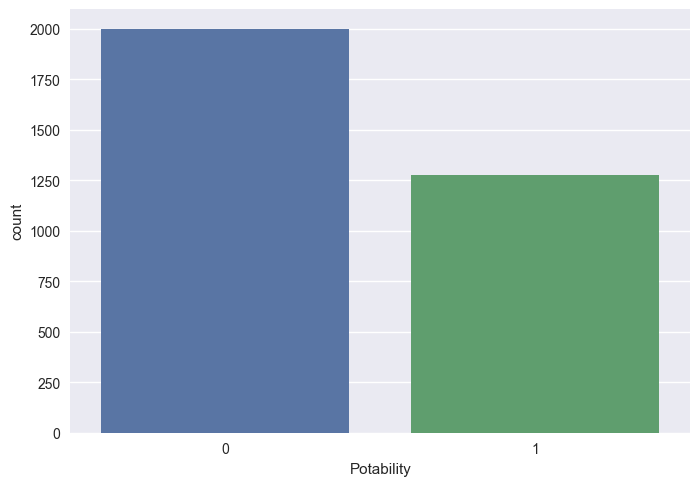

In [15]:
display(water_data['Potability'].value_counts(normalize=True))
sns.countplot(data=water_data, x='Potability');

### СТРАТИФИЦИРОВАННОЕ РАЗБИЕНИЕ

#### Данное разбиение предполагает, что наблюдения, принадлежащие каждому из классов, гарантированно попадут в каждый из наборов данных в одинаковой пропорции. Для стратифицированного разбиения достаточно в функции train_test_split() задать параметр stratify, в который нужно передать столбец с метками классов, на основе которого будет производиться балансировка.

In [16]:
# Начнём с простого разделения hold-out
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=1)
print('Train:\n', y_train.value_counts(normalize=True), sep='')
print('Valid:\n', y_valid.value_counts(normalize=True), sep='')

Train:
0    0.609924
1    0.390076
Name: Potability, dtype: float64
Valid:
0    0.609756
1    0.390244
Name: Potability, dtype: float64


#### А что насчёт кросс-валидации? Как организовать разбиение по методу k-fold и получить одинаковые соотношения классов?Для этого вместо KFold используется кросс-валидатор StratifiedKFold. Принцип работы с ним аналогичен, только, в отличие от KFold, StratifiedKFold будет разбивать выборку на части таким образом, чтобы в тренировочных и валидационных фолдах соотношения классов были приблизительно одинаковыми.

In [17]:
skf = model_selection.StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
for train_index, valid_index in skf.split(X, y): 
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_valid, y_valid = X.iloc[valid_index], y.iloc[valid_index]
    print('Train:\n', y_train.value_counts(normalize=True), sep='')
    print('Valid:\n', y_valid.value_counts(normalize=True), sep='')
    print('-'*40)

Train:
0    0.60989
1    0.39011
Name: Potability, dtype: float64
Valid:
0    0.60989
1    0.39011
Name: Potability, dtype: float64
----------------------------------------
Train:
0    0.60989
1    0.39011
Name: Potability, dtype: float64
Valid:
0    0.60989
1    0.39011
Name: Potability, dtype: float64
----------------------------------------
Train:
0    0.60989
1    0.39011
Name: Potability, dtype: float64
Valid:
0    0.60989
1    0.39011
Name: Potability, dtype: float64
----------------------------------------


**Задание 3.3**

Ниже представлен код для генерации задачи классификации и отрисовки диаграммы рассеяния с цветовой группировкой по классам
Разбейте исходный набор данных на тренировочный и валидационный со стратификацией по классам в соотношении 80/20. В качестве значения параметра random_state возьмите число 42. Постройте диаграммы рассеяния с цветовой группировкой по классам для валидационной выборки.

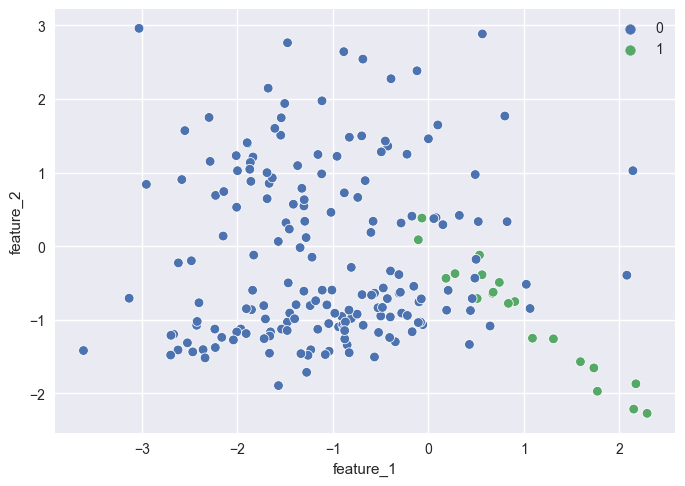

In [18]:
from sklearn import datasets
X_3, y_3 = datasets.make_classification(
    n_samples=200, #количество объектов
    n_features=2, #количество признаков
    n_informative=2, #количество информативных признаков
    n_redundant=0, #количество неинформативных признаков
    n_classes=2, #количество классов
    weights=[1, 0.2], #пропорции классов
    random_state=40 #генератор случайных чисел
)
X_3 = pd.DataFrame(X_3, columns=['feature_1', 'feature_2'])
y_3 = pd.Series(y_3)
sns.scatterplot(x=X_3['feature_1'], y=X_3['feature_2'], hue=y_3);

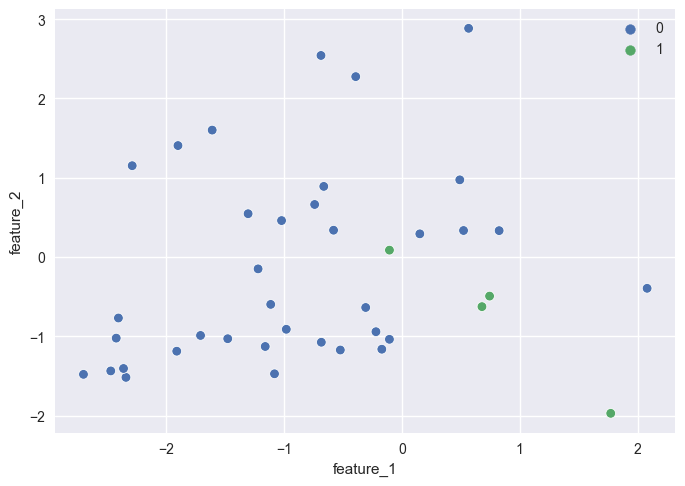

In [19]:
X_train_3, X_valid_3, y_train_3, y_valid_3 = model_selection.train_test_split(X_3, y_3, stratify=y_3, test_size=0.2, random_state=42)

sns.scatterplot(x=X_valid_3['feature_1'], y=X_valid_3['feature_2'], hue=y_valid_3);


### ВЫБОР МЕТРИК В УСЛОВИЯХ ДИСБАЛАНСА КЛАССОВ

#### Разобьём выборку на тренировочную и валидационную в соотношении 80/20, используя стратифицированное разбиение, затем обучим модель дерева решений, сделаем предсказание для каждой из выборок и сформируем отчёт о метриках на валидационной выборке с помощью функции classification_report().

In [20]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42, #генератор случайных чисел
)
#Обучаем модель на тренировочной выборке
model.fit(X_train, y_train)
#Делаем предсказание для каждой из выборок
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)
#Выводим значения метрик
print(metrics.classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

           0       0.76      0.92      0.83       400
           1       0.81      0.55      0.65       256

    accuracy                           0.77       656
   macro avg       0.78      0.73      0.74       656
weighted avg       0.78      0.77      0.76       656



**Задание 3.5**
Для выполнения этого задания используйте сгенерированные тренировочную и валидационную выборки из задания 3.3.
Обучите модель логистической регрессии на тренировочной выборке (все параметры оставьте по умолчанию).
Сделайте предсказание для валидационной выборки и рассчитайте метрики классификации.

In [21]:
log_reg_3_5 = linear_model.LogisticRegression()
#Обучаем модель, минизируя logloss
log_reg_3_5.fit(X_train_3, y_train_3)
#Делаем предсказание класса
y_pred = log_reg_3_5.predict(X_valid_3)

print(metrics.classification_report(y_valid_3, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.97      0.95        36
           1       0.50      0.25      0.33         4

    accuracy                           0.90        40
   macro avg       0.71      0.61      0.64        40
weighted avg       0.88      0.90      0.88        40



**Задание 3.6** (на самопроверку)

Воспользуйтесь функцией plot_probabilities_2d(), которую мы написали в модуле по классификации, для того чтобы построить разделяющую поверхность логистической регрессии.
Передайте в её аргументы матрицу наблюдений X, вектор ответов y и обученную в задании 3.5 логистическую регрессию.

c:\Python310\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


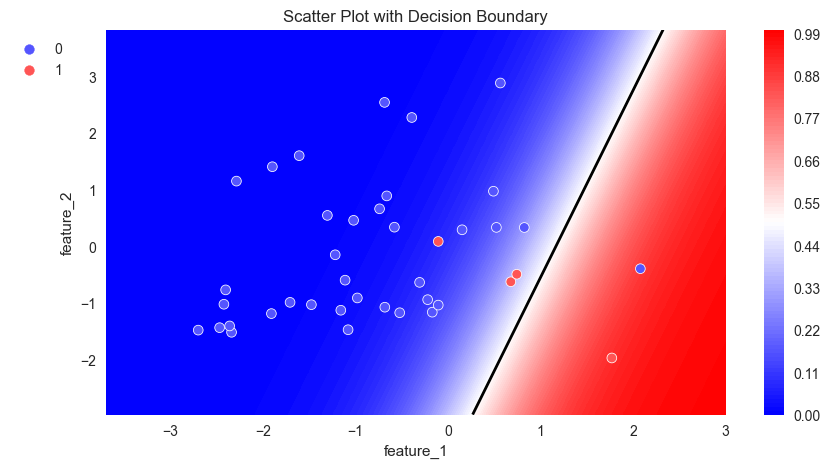

In [22]:
def plot_probabilities_2d(X, y, model):
    #Генерируем координатную сетку из всех возможных значений для признаков
    #Результат работы функции — два массива xx1 и xx2, которые образуют координатную сетку
    xx1, xx2 = np.meshgrid(
        np.arange(X.iloc[:, 0].min()-1, X.iloc[:, 0].max()+1, 0.1),
        np.arange(X.iloc[:, 1].min()-1, X.iloc[:, 1].max()+1, 0.1)
    )
    #Вытягиваем каждый из массивов в вектор-столбец — reshape(-1, 1)
    #Объединяем два столбца в таблицу с помощью hstack
    X_net = np.hstack([xx1.reshape(-1, 1), xx2.reshape(-1, 1)])
    #Предсказываем вероятность для всех точек на координатной сетке
    #Нам нужна только вероятность класса 1
    probs = model.predict_proba(X_net)[:, 1]
    #Переводим столбец из вероятностей в размер координатной сетки
    probs = probs.reshape(xx1.shape)
    #Создаём фигуру и координатную плоскость
    fig, ax = plt.subplots(figsize = (10, 5))
    #Рисуем тепловую карту вероятностей
    contour = ax.contourf(xx1, xx2, probs, 100, cmap='bwr')
    #Рисуем разделяющую плоскость — линию, где вероятность равна 0.5
    bound = ax.contour(xx1, xx2, probs, [0.5], linewidths=2, colors='black');
    #Добавляем цветовую панель 
    colorbar = fig.colorbar(contour)
    #Накладываем поверх тепловой карты диаграмму рассеяния
    sns.scatterplot(x=X.iloc[:, 0], y=X.iloc[:, 1], hue=y, palette='seismic', ax=ax)
    #Даём графику название
    ax.set_title('Scatter Plot with Decision Boundary');
    #Смещаем легенду в верхний левый угол вне графика
    ax.legend(bbox_to_anchor=(-0.05, 1))
    
plot_probabilities_2d(X_valid_3, y_valid_3, log_reg_3_5)

### ПОСТРОЕНИЕ МОДЕЛИ В УСЛОВИЯХ ДИСБАЛАНСА КЛАССОВ

#### ВЗВЕШИВАНИЕ ОБЪЕКТОВ

#### Для того чтобы задать веса классам по приведённым выше формулам, достаточно в инициализаторе модели выставить параметр class_weight='balanced'.

In [23]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42, #генератор случайных чисел
    class_weight='balanced' #веса классов
)
#Обучаем модель на тренировочной выборке
model.fit(X_train, y_train)
#Делаем предсказание для каждой из выборок
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)
#Выводим значения метрик    
print(metrics.classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

           0       0.82      0.71      0.76       400
           1       0.63      0.76      0.69       256

    accuracy                           0.73       656
   macro avg       0.72      0.73      0.72       656
weighted avg       0.74      0.73      0.73       656



**Задание 3.7**

Для выполнения этого задания используйте сгенерированные тренировочную и валидационную выборки из задания 3.3.
Обучите модель логистической регрессии на тренировочной выборке, установив сбалансированные веса для классов.
Сделайте предсказание для валидационной выборки и рассчитайте метрики классификации. 

In [24]:
log_reg_3_7 = linear_model.LogisticRegression(class_weight='balanced')
#Обучаем модель, минизируя logloss
log_reg_3_7.fit(X_train_3, y_train_3)
#Делаем предсказание класса
y_pred = log_reg_3_7.predict(X_valid_3)

print(metrics.classification_report(y_valid_3, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.83      0.90        36
           1       0.33      0.75      0.46         4

    accuracy                           0.82        40
   macro avg       0.65      0.79      0.68        40
weighted avg       0.90      0.82      0.85        40



**Задание 3.8** (на самопроверку)

Воспользуйтесь функцией plot_probabilities_2d(), которую мы написали в модуле по классификации, для того чтобы построить разделяющую поверхность логистической регрессии со сбалансированными весами классов.
Передайте в её аргументы матрицу наблюдений X, вектор ответов y и обученную в задании 3.7 логистическую регрессию.
Сравните разделяющую поверхность, построенную в задании 3.5, с полученной вами поверхностью в данном задании.

c:\Python310\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


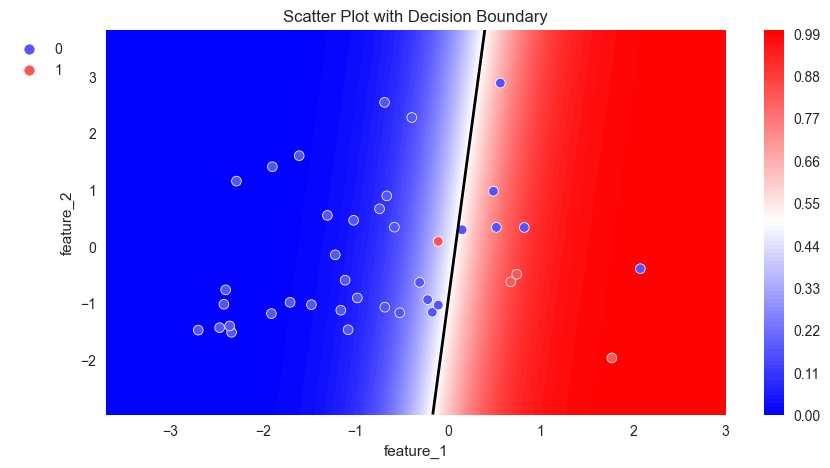

In [25]:
plot_probabilities_2d(X_valid_3, y_valid_3, log_reg_3_7)

#### ВЫБОР ПОРОГА ВЕРОЯТНОСТИ (бинаризации). PR-КРИВАЯ

#### **PR-кривая (precision-recall curve)** — это график зависимости precision от recall при различных значениях порога вероятности.

#### Для предсказания вероятностей используем функцию `cross_val_predict()`. Данная функция выполняет кросс-валидацию и возвращает предсказания для валидационных фолдов. Если ей передать параметр method='predict_proba', она вернёт предсказанные вероятности для каждого из классов на всех фолдах. Остальные параметры аналогичны параметрам функции `cross_validate()`.

In [26]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42 #генератор случайных чисел 
)
#Обучаем модель
model.fit(X_train, y_train)
#Создаём кросс-валидатор k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)
#Делаем предсказание вероятностей на кросс-валидации
y_cv_proba_pred = model_selection.cross_val_predict(model, X_train, y_train, cv=skf, method='predict_proba')

#Выделяем столбец с вероятностями для класса 1 
y_cv_proba_pred = y_cv_proba_pred[:, 1]
y_cv_proba_pred

array([1.        , 0.75438596, 0.        , ..., 0.39378238, 0.        ,
       0.96969697])

#### Теперь мы можем построить PR-кривую. Для этого воспользуемся функций `precision_recall_curve()` из модуля metrics библиотеки sklearn. В данную функцию нужно передать истинные метки классов и предсказанные вероятности. Взамен она вернёт три массива: значения метрик precision и recall, вычисленных на различных порогах вероятности, и сами пороги вероятности:

In [27]:
#Вычисляем координаты PR-кривой
precision, recall, thresholds = metrics.precision_recall_curve(y_train, y_cv_proba_pred)

print('Thresholds:', thresholds[:5])
print('Precision scores:', precision[:5])
print('Recall scores:',recall[:5])

Thresholds: [0.         0.02739726 0.02898551 0.05       0.07407407]
Precision scores: [0.39007634 0.50050659 0.50357873 0.50437919 0.5043837 ]
Recall scores: [1.         0.9667319  0.96379648 0.95792564 0.95694716]


#### Осталось дело за малым. Вычислим значение -score при различных порогах вероятности и найдём такой порог вероятности, при котором она максимальна. Сделать это можно с помощью функции `argmax()` из модуля numpy — она возвращает индекс максимального элемента массива. Далее построим PR-кривую и отметим на ней точку максимума -score.

Best threshold = 0.33, F1-Score = 0.69


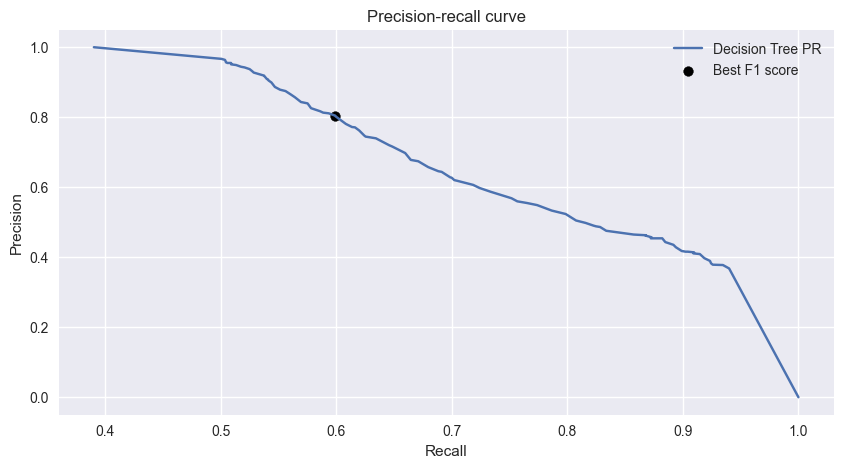

In [28]:
#Вычисляем F1-score при различных threshold
f1_scores = (2 * precision * recall) / (precision + recall)
#Определяем индекс максимума
idx = np.argmax(f1_scores)
print('Best threshold = {:.2f}, F1-Score = {:.2f}'.format(thresholds[idx], f1_scores[idx]))
 
#Строим PR-кривую
fig, ax = plt.subplots(figsize=(10, 5)) #фигура + координатная плоскость
#Строим линейный график зависимости precision от recall
ax.plot(precision, recall, label='Decision Tree PR')
#Отмечаем точку максимума F1
ax.scatter(precision[idx], recall[idx], marker='o', color='black', label='Best F1 score')
#Даём графику название и подписываем оси
ax.set_title('Precision-recall curve')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
#Отображаем легенду
ax.legend();

#### Итак, согласно нашим вычислениям и построенной PR-кривой, максимум  (0.69) на кросс-валидации наблюдается при пороге вероятности 0.33. Сделаем предсказание классов с таким порогом для всех объектов из отложенной валидационной выборки и выведем отчёт о метриках:

In [29]:
#Образцы воды, для которых вероятность быть пригодными для питья > threshold_opt, относим к классу 1
#В противном случае — к классу 0
y_valid_pred_proba = model.predict_proba(X_valid)[:, 1]
y_valid_pred = (y_valid_pred_proba > thresholds[idx]).astype('int')
#Считаем метрики
print(metrics.classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

           0       0.82      0.71      0.76       400
           1       0.62      0.76      0.68       256

    accuracy                           0.73       656
   macro avg       0.72      0.73      0.72       656
weighted avg       0.74      0.73      0.73       656



#### **Примечание**. Чтобы вычислить площадь под PR-кривой, используется функция `auc()` из модуля metrics библиотеки sklearn. В данную функцию нужно передать значения метрик recall и precision при различных порогах вероятности:

In [30]:
print('PR AUC: {:.2f}'.format(metrics.auc(recall, precision)))

PR AUC: 0.79


### СЭМПЛИРОВАНИЕ (пересэмплирование, oversampling)

#### Идея очень проста: если у нас мало наблюдений миноритарного класса, следует искусственно увеличить их количество.

#### Алгоритмов сэмплирования, в том числе **SMOTE**, нет в стандартном пакете sklearn — они содержатся в библиотеке imblearn (imbalanced-learn). Команды для установки приведены далее. Все алгоритмы пересэмплирования находятся в модуле over_sampling Устанавливаем  библиотеки и мпортируем оттуда алгоритм SMOTE:

In [31]:
%pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [32]:
from imblearn.over_sampling import SMOTE

#### Создадим объект класса SMOTE и вызовем у него метод fit_resample(), передав в него обучающую выборку (X_train, y_train). Затем выведем количество наблюдений каждого из классов до и после сэмплирования:

In [33]:
sm = SMOTE(random_state=2)
X_train_s, y_train_s = sm.fit_resample(X_train, y_train)

print('Train shape before oversampling:', X_train.shape) 
print('Class balance before oversampling: \n', y_train.value_counts(), sep='')
print('-'*40)
print('Train shape after oversampling:', X_train_s.shape)
print('Class balance after oversampling: \n', y_train_s.value_counts(), sep='')

Train shape before oversampling: (2620, 9)
Class balance before oversampling: 
0    1598
1    1022
Name: Potability, dtype: int64
----------------------------------------
Train shape after oversampling: (3196, 9)
Class balance after oversampling: 
0    1598
1    1598
Name: Potability, dtype: int64


In [34]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42, #генератор случайных чисел
)
#Обучаем модель на тренировочной выборке (с сэмплированием)
model.fit(X_train_s, y_train_s)
#Делаем предсказание для каждой из выборок
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)
#Выводим значения метрик    
print(metrics.classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

           0       0.83      0.70      0.76       400
           1       0.63      0.78      0.69       256

    accuracy                           0.73       656
   macro avg       0.73      0.74      0.73       656
weighted avg       0.75      0.73      0.73       656



**Задание 3.11**

Для выполнения этого задания используйте сгенерированные тренировочную и валидационную выборки из задания 3.3.
Сбалансируйте тренировочную выборку с помощью алгоритма SMOTE. В качестве значения параметра random_state возьмите число 42, остальные параметры оставьте по умолчанию.
Обучите модель логистической регрессии на пересэмплированной тренировочной выборке. Все параметры оставьте по умолчанию.
Сделайте предсказание для валидационной выборки и рассчитайте метрики классификации. Ответ округлите до двух знаков после точки-разделителя.

In [35]:
sm = SMOTE(random_state=42)
X_train_3_s, y_train_3_s = sm.fit_resample(X_train_3, y_train_3)

print('Train shape before oversampling:', X_train.shape) 
print('Class balance before oversampling: \n', y_train_3.value_counts(), sep='')
print('-'*40)
print('Train shape after oversampling:', X_train_s.shape)
print('Class balance after oversampling: \n', y_train_3_s.value_counts(), sep='')

Train shape before oversampling: (2620, 9)
Class balance before oversampling: 
0    144
1     16
dtype: int64
----------------------------------------
Train shape after oversampling: (3196, 9)
Class balance after oversampling: 
0    144
1    144
dtype: int64


In [36]:
log_reg_3_11 = linear_model.LogisticRegression()
#Обучаем модель, минизируя logloss
log_reg_3_11.fit(X_train_3_s, y_train_3_s)
#Делаем предсказание класса
y_pred_3_11 = log_reg_3_11.predict(X_valid_3)

print(metrics.classification_report(y_valid_3, y_pred_3_11))

              precision    recall  f1-score   support

           0       0.97      0.89      0.93        36
           1       0.43      0.75      0.55         4

    accuracy                           0.88        40
   macro avg       0.70      0.82      0.74        40
weighted avg       0.92      0.88      0.89        40



**Задание 3.12** (на самопроверку)
Воспользуйтесь функцией plot_probabilities_2d(), которую мы написали в модуле по классификации, для того чтобы построить разделяющую поверхность логистической регрессии со сбалансированными весами классов. Передайте в её аргументы матрицу наблюдений X, вектор ответов y и обученную в задании 3.11 логистическую регрессию. Сравните разделяющую поверхность, построенную в заданиях 3.5 и 3.7, с полученной вами поверхностью в данном задании.

c:\Python310\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


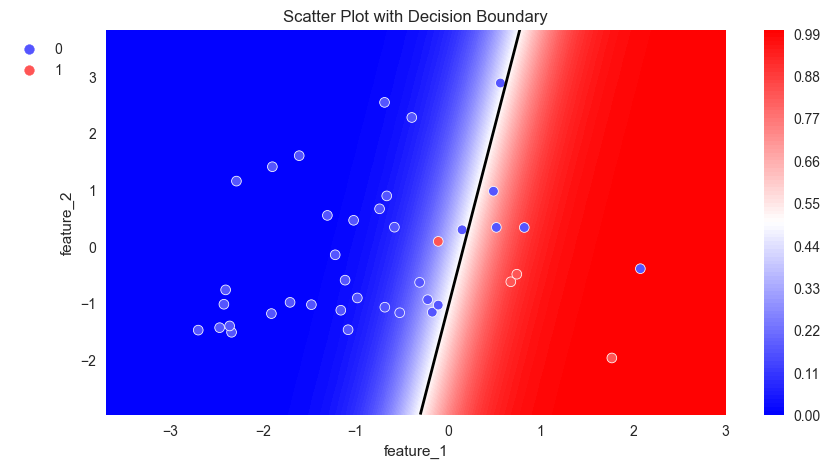

In [37]:
plot_probabilities_2d(X_valid_3, y_valid_3, log_reg_3_11);


### КАК ОБНАРУЖИТЬ ПЕРЕОБУЧЕНИЕ

#### Основные способы отследить переобучение:

- hold-out-разбиение,
- k-fold-валидация и leave-one-out-валидация,
- кривые обучения (learning curves)

### hold-out

#### Для этого стратифицированно разобьём набор данных на тренировочную и валидационную выборки в соотношении 80/20 и обучим дерево решений с энтропией  в качестве критерия информативности и сбалансированными весами классов без ограничения его глубины и количества объектов в листе. Сделаем предсказание для каждой из выборок и рассчитаем метрику F1-score

In [38]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
#Создаём модель
model_bad = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    class_weight='balanced', #веса классов
    random_state=42 #генератор случайных чисел
)
#Обучаем модель на тренировочной выборке
model_bad.fit(X_train, y_train)
#Делаем предсказание для каждой из выборок
y_train_pred = model_bad.predict(X_train)
y_valid_pred = model_bad.predict(X_valid)
#Выводим значения метрик для тренировочной выборки
print('Train F1 score: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
#Выводим значения метрик для валидационной выборки
print('Valid F1 score: {:.2f}'.format(metrics.f1_score(y_valid, y_valid_pred)))

Train F1 score: 1.00
Valid F1 score: 0.67


### k-fold

#### Организуем стратифицированную кросс-валидацию на пяти фолдах. На каждом шаге кросс-валидации будем вычислять метрику F1 на тренировочных и валидационных фолдах.

In [39]:
#Создаём объект кросс-валидатора k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)
 
#Считаем метрики на кросс-валидации k-fold со стратификацией
cv_metrics = model_selection.cross_validate(
    estimator=model_bad, #модель
    X=X, #матрица наблюдений X
    y=y, #вектор ответов y
    cv=skf, #кросс-валидатор
    scoring='f1', #метрика
    return_train_score=True #подсчёт метрики на тренировочных фолдах
)
display(cv_metrics)

{'fit_time': array([0.15623832, 0.12430191, 0.21760201, 0.15831304, 0.16531229]),
 'score_time': array([0.00874233, 0.00694871, 0.00893879, 0.00695348, 0.00695348]),
 'test_score': array([0.61445783, 0.68421053, 0.62332696, 0.63276836, 0.70119522]),
 'train_score': array([1., 1., 1., 1., 1.])}

In [40]:
# Подсчитаем среднее значение F1
print('Train k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print('Valid k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['test_score'])))

Train k-fold mean f1: 1.00
Valid k-fold mean f1: 0.65


**Задание 4.3**

Разделите исходный набор данных на тренировочную и валидационную выборки в соотношении 70/30, используя функцию train_test_split(). В качестве значения параметра random_state возьмите число 42.
Обучите модель дерева решений с глубиной 10 (остальные параметры оставьте по умолчанию) для решения задачи классификации на тренировочной выборке. Сделайте предсказания для тренировочной и валидационной выборок и рассчитайте метрику accuracy.
В качестве ответа укажите значение метрики accuracy на тренировочной и валидационной выборках. Ответ округлите до двух знаков после точки-разделителя.

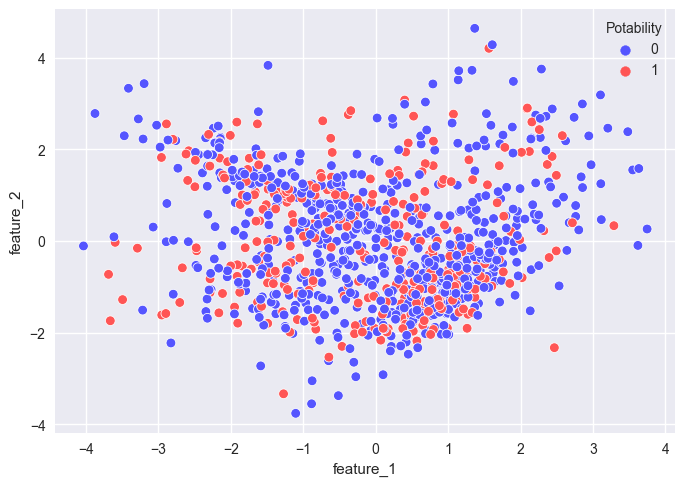

In [42]:
from sklearn import datasets
X_4_3, y_4_3 = datasets.make_classification(
    n_samples=1000, #количество объектов
    n_features=2, #количество признаков
    n_informative=2, #количество информативных признаков
    n_redundant=0, #количество неинформативных признаков
    n_classes=2, #количество классов
    n_clusters_per_class=2, #количество кластеров внутри класса
    random_state=1 #генератор случайных чисел
)
X_4_3 = pd.DataFrame(X_4_3, columns=['feature_1', 'feature_2'])
y_4_3 = pd.Series(y_4_3)
sns.scatterplot(x=X_4_3['feature_1'], y=X_4_3['feature_2'], hue=y, palette='seismic');

In [43]:
X_train_4_3, X_valid_4_3, y_train_4_3, y_valid_4_3 = model_selection.train_test_split(X_4_3, y_4_3, test_size=0.3, random_state=42)
#Создаём модель
model_4_3 = tree.DecisionTreeClassifier(max_depth=10)
#Обучаем модель на тренировочной выборке
model_4_3.fit(X_train_4_3, y_train_4_3)
#Делаем предсказание для каждой из выборок
y_train_pred_4_3 = model_4_3.predict(X_train_4_3)
y_valid_pred_4_3 = model_4_3.predict(X_valid_4_3)
#Выводим значения метрик для тренировочной выборки
print('Train accuracy: {:.2f}'.format(metrics.accuracy_score(y_train_4_3, y_train_pred_4_3)))
#Выводим значения метрик для валидационной выборки
print('Valid accuracy: {:.2f}'.format(metrics.accuracy_score(y_valid_4_3, y_valid_pred_4_3)))

Train accuracy: 0.98
Valid accuracy: 0.81


**Задание 4.4** (на самопроверку)

Воспользуйтесь функцией plot_probabilities_2d() и постройте разделяющую поверхность обученного дерева решений.
Передайте в её аргументы матрицу наблюдений X, вектор ответов y и обученное в задании 4.3 дерево решений.
Является ли ваша модель переобученной?

c:\Python310\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


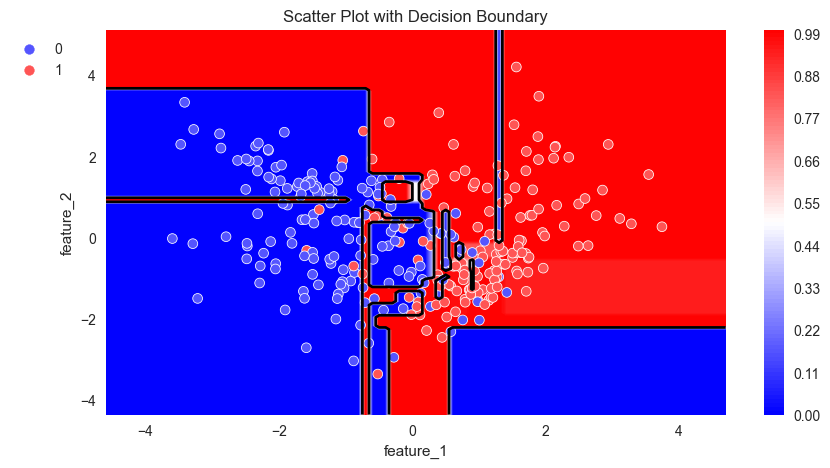

In [44]:
plot_probabilities_2d(X_valid_4_3, y_valid_4_3, model_4_3);

### МЕТОДЫ БОРЬБЫ С ПЕРЕОБУЧЕНИЕМ

#### На реальных данных, подверженных зашумлённости, такой подход в большинстве случаев приводит к переобучению дерева: глубина становится очень большой, и дерево не отражает общих зависимостей в данных. В таком случае в первую очередь прибегают к «обрезке» деревьев путём ограничения максимальной глубины и/или увеличения количества объектов, при которых вершина дерева превращается в лист и деление прекращается.

In [45]:
# Текущая глубина дерева
print('Current depth:', model_bad.get_depth())

Current depth: 27


#### Дерево глубиной 27 — это очень сложная модель. Давайте попробуем её упростить, добавив в дерево решений ограничение на глубину (max_depth). Пусть максимальная глубина дерева будет равна 7.

In [46]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #ограничиваем глубину дерева
    random_state=42, #генератор случайных чисел
    class_weight='balanced' #веса классов
)
 
#Создаём объект кросс-валидатора k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)
 
#Считаем метрики на кросс-валидации k-fold со стратификацией
cv_metrics = model_selection.cross_validate(
    estimator=model, #модель
    X=X, #матрица наблюдений X
    y=y, #вектор ответов y
    cv=skf, #кросс-валидатор
    scoring='f1', #метрика
    return_train_score=True #подсчёт метрики на тренировочных фолдах
)
 
print('Train k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print('Valid k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['test_score'])))

Train k-fold mean f1: 0.75
Valid k-fold mean f1: 0.66


#### Попробуем добавить ещё одно ограничение к нашему дереву: увеличим количество объектов, которых достаточно для образования листа дерева (min_samples_leaf). По умолчанию этот параметр равен 1. 

In [47]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #ограничиваем глубину дерева
    min_samples_leaf=5, #увеличиваем количество объектов в листе
    random_state=42, #генератор случайных чисел
    class_weight='balanced' #веса классов
)
 
#Создаём объект кросс-валидатора k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)
 
#Считаем метрики на кросс-валидации k-fold со стратификацией
cv_metrics = model_selection.cross_validate(
    estimator=model, #модель
    X=X, #матрица наблюдений X
    y=y, #вектор ответов y
    cv=skf, #кросс-валидатор
    scoring='f1', #метрика
    return_train_score=True #подсчёт метрики на тренировочных фолдах
)
 
print('Train k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print('Valid k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['test_score'])))

Train k-fold mean f1: 0.74
Valid k-fold mean f1: 0.66


**Задание 4.6**

Для выполнения этого задания используйте сгенерированные тренировочную и валидационную выборки из задания 4.3.
Обучите модель дерева решений с глубиной 3 (остальные параметры оставьте по умолчанию) для решения задачи классификации на тренировочной выборке.
Сделайте предсказания для тренировочной и валидационной выборок и рассчитайте метрику accuracy.
В качестве ответа укажите значение метрики accuracy на тренировочной и валидационной выборках. Ответ округлите до двух знаков после точки-разделителя.

In [48]:
model_4_6 = tree.DecisionTreeClassifier(max_depth=3)
#Обучаем модель на тренировочной выборке
model_4_6.fit(X_train_4_3, y_train_4_3)
#Делаем предсказание для каждой из выборок
y_train_pred_4_6 = model_4_6.predict(X_train_4_3)
y_valid_pred_4_6 = model_4_6.predict(X_valid_4_3)
#Выводим значения метрик для тренировочной выборки
print('Train accuracy: {:.2f}'.format(metrics.accuracy_score(y_train_4_3, y_train_pred_4_6)))
#Выводим значения метрик для валидационной выборки
print('Valid accuracy: {:.2f}'.format(metrics.accuracy_score(y_valid_4_3, y_valid_pred_4_6)))

Train accuracy: 0.88
Valid accuracy: 0.85


**Задание 4.7** (на самопроверку)

Воспользуйтесь функцией plot_probabilities_2d() и постройте разделяющую поверхность обученного дерева решений. Передайте в её аргументы матрицу наблюдений X, вектор ответов y и обученное в задании 4.6 дерево решений. Удалось ли вам избавиться от переобучения модели?

c:\Python310\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


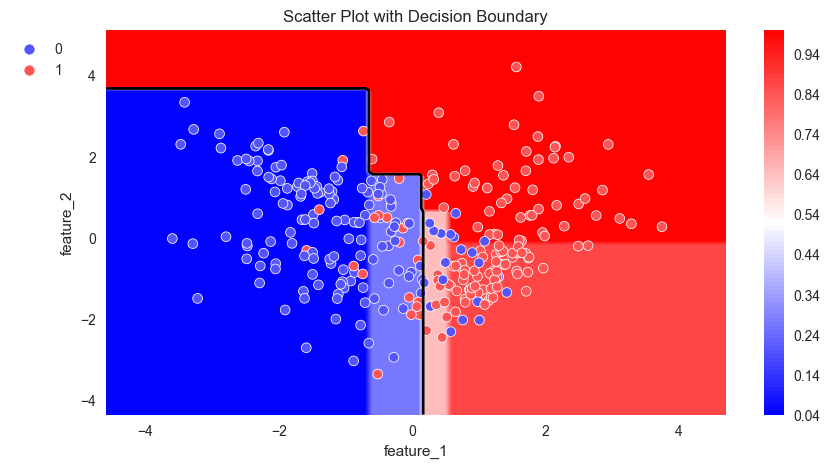

In [49]:
plot_probabilities_2d(X_valid_4_3, y_valid_4_3, model_4_6);

### КРИВАЯ ОБУЧЕНИЯ

#### **Кривая обучения (learning curve)** — это график зависимости некоторой метрики на обучающем (валидационном) наборе данных от количества объектов, которые участвуют в обучении модели.

#### ПОСТРОЕНИЕ КРИВОЙ ОБУЧЕНИЯ

#### Для вычисления точек для построения кривых обучения в модуле model_selection библиотеки sklearn есть функция `learning_curve()`, который возвращает три массива:
- Список из размеров тренировочного набора (ось абсцисс кривой обучения).
- Матрица из метрик, полученных при разных размерах тренировочного набора во время кросс-валидации на тренировочных фолдах. В строках этой таблицы указаны списки метрик, соответствующие каждому размеру тренировочного набора данных, а внутри списков находятся сами метрики на кросс-валидации.
- Матрица из метрик, полученных при разных размерах тренировочного набора во время кросс-валидации на валидационных фолдах.

In [50]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    class_weight='balanced', 
    random_state=42, #генератор случайных чисел 
)
 
#Создаём объект кросс-валидатора k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)
 
#Вычисляем координаты для построения кривой обучения
train_sizes, train_scores, valid_scores = model_selection.learning_curve(
    estimator = model, #модель
    X = X, #матрица наблюдений X
    y = y, #вектор ответов y
    cv = skf, #кросс-валидатор
    scoring = 'f1' #метрика
)
print('Train sizes: \n', train_sizes)
print('Train scores: \n', train_scores)
print('Valid scores: \n', valid_scores)

Train sizes: 
 [ 262  851 1441 2030 2620]
Train scores: 
 [[0.8        0.72727273 0.72727273 0.72727273 0.72727273]
 [0.76156584 0.82522523 0.8757764  0.8757764  0.8757764 ]
 [0.78546099 0.80108011 0.78497653 0.78183613 0.78183613]
 [0.75440806 0.74526573 0.72822528 0.76443265 0.75997384]
 [0.73336393 0.75992939 0.72322275 0.74051593 0.76085963]]
Valid scores: 
 [[0.62222222 0.2228739  0.18128655 0.25329815 0.28486647]
 [0.64528302 0.4978903  0.46031746 0.53831776 0.56928839]
 [0.59622642 0.60687023 0.60805861 0.56624319 0.60820896]
 [0.60903733 0.68641115 0.63859649 0.59344894 0.67407407]
 [0.61981982 0.6797153  0.66294227 0.61689587 0.71719039]]


#### Для того чтобы вычислить среднюю кросс-валидационную метрику на каждом из наборов данных, необходимо рассчитать среднее по столбцам матриц train_scores и valid_scores

In [51]:
train_scores_mean = np.mean(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
 
print('Train k-fold f1 scores',  train_scores_mean)
print('Valid k-fold f1 scores',  valid_scores_mean)

Train k-fold f1 scores [0.74181818 0.84282405 0.78703798 0.75046111 0.74357833]
Valid k-fold f1 scores [0.31290946 0.54221938 0.59712148 0.6403136  0.65931273]


#### Теперь можно построить графики кривых обучения:

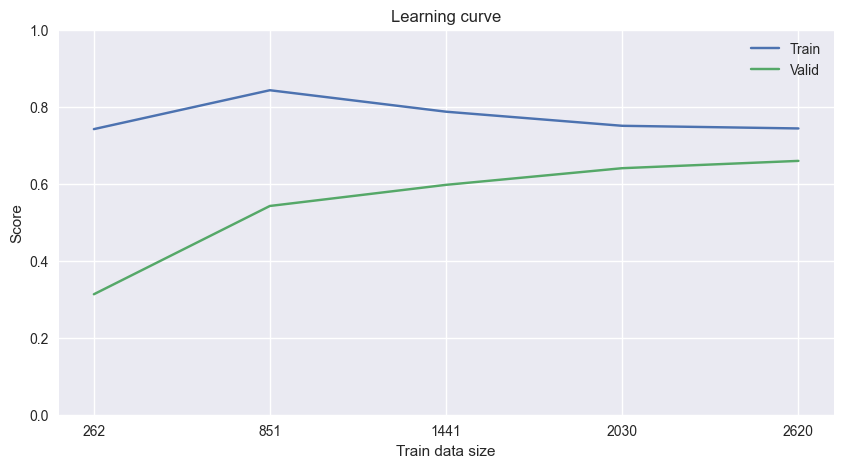

In [52]:
#Визуализируем кривую обучения
fig, ax = plt.subplots(figsize=(10, 5)) #фигура + координатная плоскость
#Строим кривую обучения по метрикам на тренировочных фолдах
ax.plot(train_sizes, train_scores_mean, label='Train')
#Строим кривую обучения по метрикам на валидационных фолдах
ax.plot(train_sizes, valid_scores_mean, label='Valid')
#Даём название графику и подписи осям
ax.set_title('Learning curve')
ax.set_xlabel('Train data size')
ax.set_ylabel('Score')
#Устанавливаем отметки по оси абсцисс
ax.xaxis.set_ticks(train_sizes)
#Устаналиваем диапазон оси ординат
ax.set_ylim(0, 1)
#Отображаем легенду
ax.legend();

#### давайте построим кривые обучения для нескольких моделей. Будем использовать следующие модели  (создадим их список])
- логистическую регрессию,
- дерево решений с ограниченной максимальной глубиной и количеством объектов в листе,
- дерево решений без ограничений.

In [53]:
#Создаём список из моделей
models = [
    linear_model.LogisticRegression(
        max_iter=1000, #количество итераций на сходимость
        random_state=42, #генератор случайных чисел
        class_weight='balanced' #веса классов
    ),
    tree.DecisionTreeClassifier(
        criterion='entropy', #критерий информативности
        max_depth=7, #максимальная глубина
        min_samples_leaf=5, #минимальное число объектов в листе
        random_state=42, #генератор случайных чисел 
        class_weight='balanced' #веса классов
    ),
    tree.DecisionTreeClassifier(
        criterion='entropy', #критерий информативности
        random_state=42, #генератор случайных чисел 
        class_weight='balanced' #веса классов
    ),
]

#### построим кривые обучения для каждой из моделей. Для этого заранее создадим k-fold-кросс-валидатор со стратификацией на пять фолдов. Создадим фигуру с тремя координатными плоскостями. Реализуем цикл по составленному списку из моделей и их индексам (они нам понадобятся для отображения на соответствующих координатных плоскостях). Внутри цикла будем вызывать нашу функцию `plot_learning_curve()`:

In [88]:
def plot_learning_curve(model, X, y, cv, scoring="f1", ax=None, title=""):
    # Вычисляем координаты для построения кривой обучения
    train_sizes, train_scores, valid_scores = model_selection.learning_curve(
        estimator=model,  # модель
        X=X,  # матрица наблюдений X
        y=y,  # вектор ответов y
        cv=cv,  # кросс-валидатор
        scoring=scoring,  # метрика
    )
    # Вычисляем среднее значение по фолдам для каждого набора данных
    train_scores_mean = np.mean(train_scores, axis=1)
    valid_scores_mean = np.mean(valid_scores, axis=1)
    # Если координатной плоскости не было передано, создаём новую
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 4))  # фигура + координатная плоскость
    # Строим кривую обучения по метрикам на тренировочных фолдах
    ax.plot(train_sizes, train_scores_mean, label="Train")
    # Строим кривую обучения по метрикам на валидационных фолдах
    ax.plot(train_sizes, valid_scores_mean, label="Valid")
    # Даём название графику и подписи осям
    ax.set_title(f"Learning curve:\n{title}", fontsize=10)
    ax.set_xlabel("Train data size")
    ax.set_ylabel("Score")
        # Устанавливаем отметки по оси абсцисс
    ax.xaxis.set_ticks(train_sizes)
    # Устанавливаем диапазон оси ординат
    ax.set_ylim(0, 1.05)
    # Отображаем легенду
    ax.legend();

In [78]:
# from helpers.plot_learning_curve import plot_learning_curve

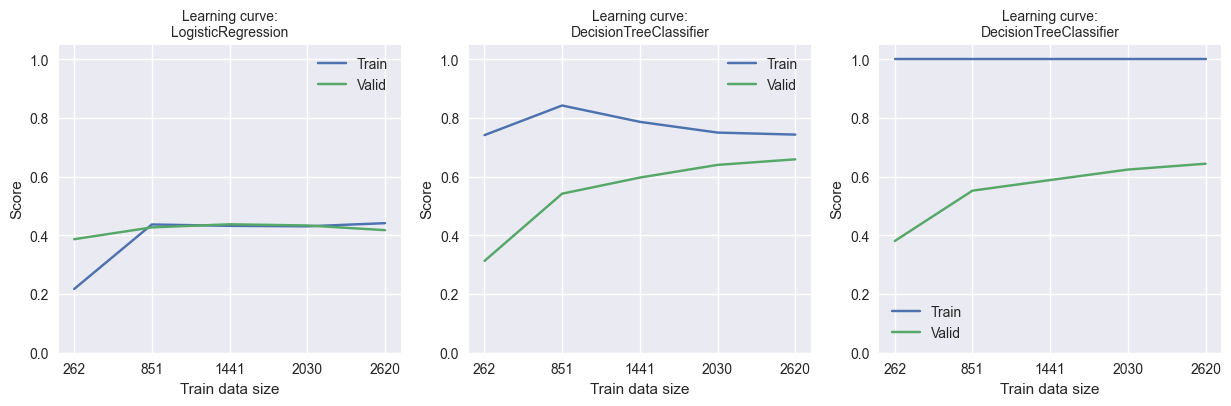

In [89]:
#Создаём объект кросс-валидатора k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)
#Визуализируем кривые обучения
fig, axes = plt.subplots(1, 3, figsize=(15, 4)) #фигура + три координатных плоскости
#Создаём цикл по списку моделей и индексам этого списка
for i, model in enumerate(models): #i — текущий индекс, model — текущая модель
    plot_learning_curve(model, X, y, skf, ax=axes[i], title=model.__class__.__name__)